# Loading Model.

In [1]:
import tensorflow.compat.v1 as tf1
##tf1.disable_v2_behavior()
from Utils import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Patch size and shift samples.
w1 = 48
w2 = 48
s1z = 1
s2z = 1



# Best Model Name
modw = 'Best_Model_Marmousi2_15.h5'

# Number of neurons per first and second sub-networks
# Reduce D1 for removing more noise
# Increase D2 for reconstructing more signals.
D1 = 225
D2 = 4225
# Call the MSMHA model
model = MSMHA(D1,D2,w1,w2, modw)


2025-06-24 22:59:34.179528: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-06-24 22:59:35.469712: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-06-24 22:59:35.470725: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-06-24 22:59:35.519749: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.53GiB deviceMemoryBandwidth: 715.34GiB/s
2025-06-24 22:59:35.519775: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-06-24 22:59:35.521529: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2025-0

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 48, 48)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2304)         0           input_layer[0][0]                
__________________________________________________________________________________________________
dense (Dense)                   (None, 225)          518625      flatten[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 225)          0           dense[0][0]                      
______________________________________________________________________________________________

# Loading data

5.601964955433899


<Figure size 640x480 with 0 Axes>

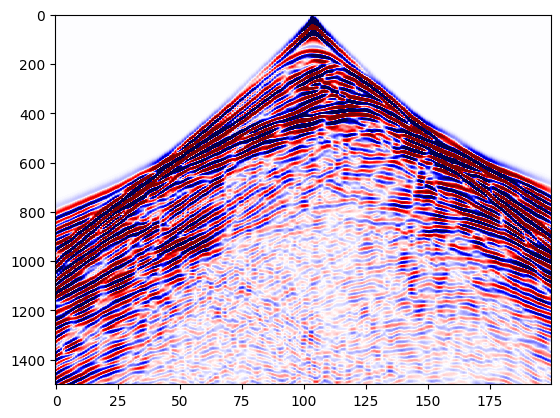

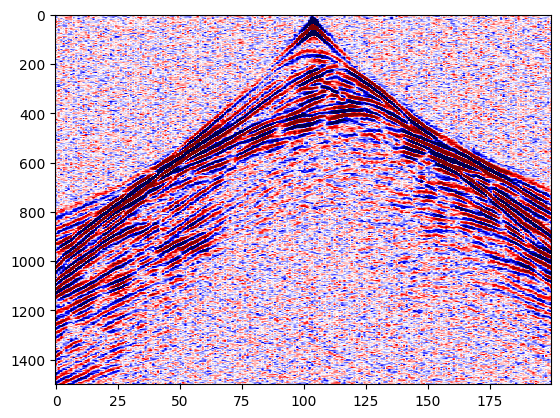

<Figure size 640x480 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt
import numpy as np

clean = np.load('data/Clean_MarmousiShot15.npy')
# Genearte noise with same shape as that of the image
#dataNoise = clean + np.random.normal(0, 0.3, clean.shape) 
dataNoise = np.load('data/Noisy_MarmousiShot15.npy')
print(yc_snr(clean,dataNoise))

#dataNoise = np.load('data/Noisy_Mar_Shot12.npy')


vmin = np.quantile(dataNoise, 0.05)
vmax = np.quantile(dataNoise, 0.95)

vmin0 = np.quantile(clean, 0.05)
vmax0 = np.quantile(clean, 0.95)
plt.figure()
plt.imshow(clean,aspect='auto',cmap='seismic',vmin = vmin0, vmax=vmax0)
plt.figure()
plt.imshow(dataNoise,aspect='auto',cmap='seismic',vmin = vmin, vmax=vmax)
plt.figure()

# Patching

In [3]:
ma = np.max(np.abs(dataNoise))/100
dataNoise1 = dataNoise/ma
#dataNoise1 = dataNoise
datapatch = yc_patch(dataNoise1,w1,w2,s1z,s2z)   
datapatch1 = np.reshape(datapatch,(datapatch.shape[0],w1,w2))

# Training in an unsupervised manner

In [4]:
import tensorflow
A = 1
def lr_schedule(epoch):
    initial_lr = 1e-4

    if epoch <= A:
        lr = initial_lr
    elif epoch <= A+20:
        lr = initial_lr / 2
    elif epoch <= A+50:
        lr = initial_lr / 10
    else:
        lr = initial_lr / 20
   # print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.5,
                                   cooldown=0,
                                   patience=5,
                                   min_lr=0.5e-6,
                                   monitor='loss')

sgd = tensorflow.keras.optimizers.Adam()
model.compile(optimizer=sgd, loss=['mse','mse'])


early_stopping_monitor = EarlyStopping(monitor= 'loss', patience = 5)

checkpoint = ModelCheckpoint(modw,
                             monitor='loss',
                             mode = 'auto',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True)


callbacks = [lr_scheduler,early_stopping_monitor, checkpoint, lr_reducer]
history = model.fit(datapatch1, [datapatch1,datapatch1], epochs=100, verbose=2, batch_size=128, shuffle=True, callbacks = callbacks)

2025-06-24 22:59:49.865779: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-06-24 22:59:49.883777: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/100


2025-06-24 22:59:50.645216: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


1737/1737 - 36s - loss: 1.9769 - reshape_1_loss: 1.1917 - reshape_3_loss: 0.7851

Epoch 00001: loss improved from inf to 1.97688, saving model to Best_Model_Marmousi2_15.h5
Epoch 2/100
1737/1737 - 35s - loss: 1.2995 - reshape_1_loss: 0.7749 - reshape_3_loss: 0.5246

Epoch 00002: loss improved from 1.97688 to 1.29947, saving model to Best_Model_Marmousi2_15.h5
Epoch 3/100
1737/1737 - 35s - loss: 1.0238 - reshape_1_loss: 0.6426 - reshape_3_loss: 0.3811

Epoch 00003: loss improved from 1.29947 to 1.02375, saving model to Best_Model_Marmousi2_15.h5
Epoch 4/100
1737/1737 - 35s - loss: 0.9409 - reshape_1_loss: 0.5877 - reshape_3_loss: 0.3532

Epoch 00004: loss improved from 1.02375 to 0.94088, saving model to Best_Model_Marmousi2_15.h5
Epoch 5/100
1737/1737 - 36s - loss: 0.8852 - reshape_1_loss: 0.5466 - reshape_3_loss: 0.3387

Epoch 00005: loss improved from 0.94088 to 0.88523, saving model to Best_Model_Marmousi2_15.h5
Epoch 6/100
1737/1737 - 36s - loss: 0.8407 - reshape_1_loss: 0.5145 - r

# Predicting the denoised version

SNR for the noisy data is:5.601964955433899SNR for the denoised version is:18.189732572516963


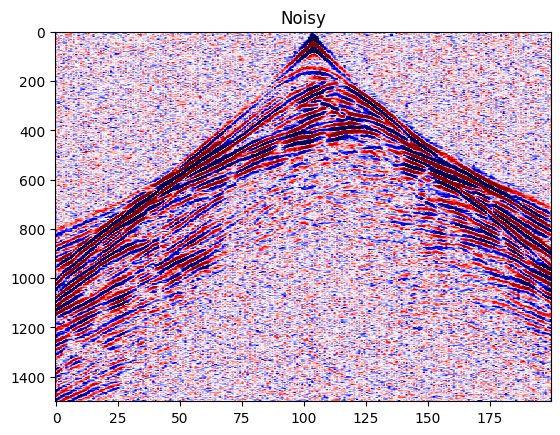

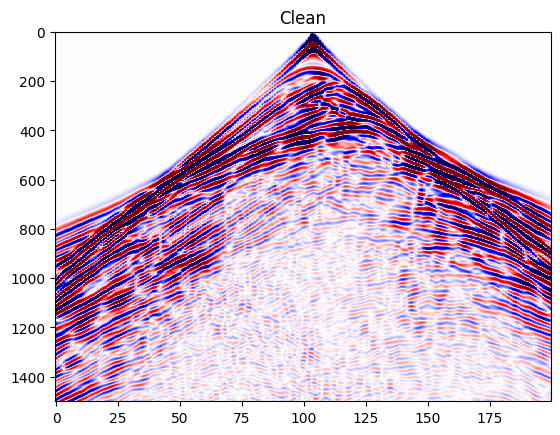

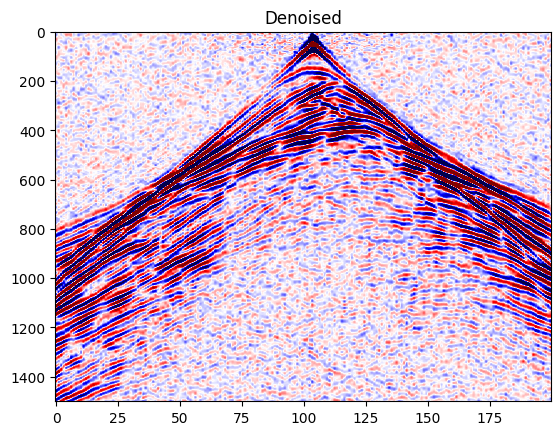

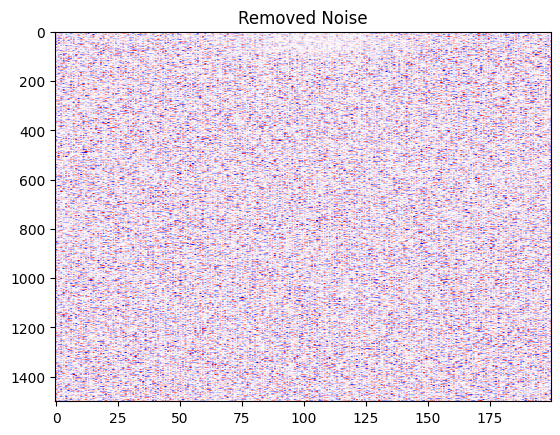

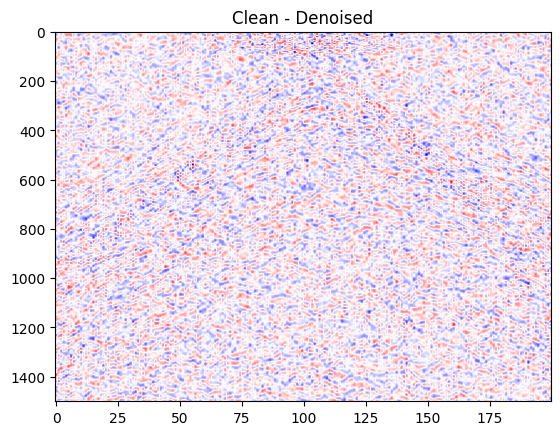

In [5]:
# Load best model
model.load_weights(modw)

# Predict
[ign,out] = model.predict([datapatch1],batch_size=128)
out = out*ma
out = np.reshape(out,(out.shape[0],w1*w2))     

# Unpatching
outA = np.transpose(out)
n1,n2=np.shape(dataNoise)
outB = yc_patch_inv(outA,n1,n2,w1,w2,s1z,s2z)
outB = np.array(outB)

# Plotting
vmin0 = np.quantile(dataNoise, 0.05)
vmax0 = np.quantile(dataNoise, 0.95)


plt.imshow(dataNoise,aspect='auto',cmap='seismic',vmin = vmin0, vmax=vmax0)
plt.title('Noisy')
plt.figure()
plt.imshow(clean,aspect='auto',cmap='seismic',vmin = vmin0, vmax=vmax0)
plt.title('Clean')
plt.figure()
plt.imshow(outB,aspect='auto',cmap='seismic',vmin = vmin0, vmax=vmax0)
plt.title('Denoised')
plt.figure()
plt.imshow(outB-dataNoise,aspect='auto',cmap='seismic',vmin = vmin0, vmax=vmax0)
plt.title('Removed Noise')
plt.figure()
plt.imshow(outB-clean,aspect='auto',cmap='seismic',vmin = vmin0, vmax=vmax0)
plt.title('Clean - Denoised')

# Save data
np.save('data/denoised_mramousi2_5',outB)

# SNR before and after MSHMA
print('SNR for the noisy data is:' + str(yc_snr(clean,dataNoise)) + 'SNR for the denoised version is:' + str(yc_snr(clean,outB)))